read model output
Calib
NSE=0.88, Bias=1.12, Variance=1.01, Correlation=0.95, KGE=0.88


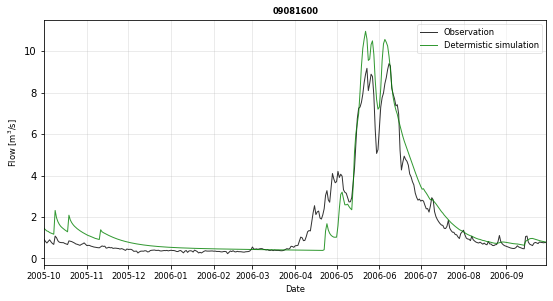

Done


In [1]:
# compare simulated and observed flow
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
#================================ Plot =======================================
def read_output(file):    
    # read csv
    time = np.loadtxt(file, usecols=[0,1,2], dtype='str', skiprows=1)
    data = np.loadtxt(file, usecols=[-2,-1], skiprows=1) #sim, obs
    data[data<0]=np.nan
    
    # convert time
    dt = []
    for i in range(len(time)):
        t_str = time[i,0]+' '+time[i,1]+' '+time[i,2]
        dt.append(datetime.strptime(t_str,'%Y %m %d'))
        
    # create dataframe (time, data)
    df = pd.DataFrame(data,columns=['sim','obs'])
    df['Date'] = dt
    df = df.set_index('Date')  
    return df


def plot_hyd(obs_df, sim_df, title_str, ylabel, ofile):
    
    row_num=1
    col_num=1        
    fig, ax = plt.subplots(row_num,col_num,figsize=[9, 9*0.5])

    dpi_value=150

    t_plot = obs_df.index
    obs = obs_df.to_numpy()
    sim = sim_df.to_numpy()    
    ax.plot_date(t_plot, obs, color='black', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8, label='Observation') 
    ax.plot_date(t_plot, sim, color='green', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8, label='Determistic simulation')  
    
    #axis, label, title, legend
    ax.set_xlim(t_plot[0],t_plot[-1])
    ax.set_title(title_str, fontsize='small', fontweight='bold')
    ax.set_xlabel('Date', fontsize='small')
    ax.set_ylabel(ylabel, fontsize='small')
    
    ax.xaxis.set_tick_params(labelsize='small')
    ax.legend(loc='best', fontsize='small', framealpha=0.5) 

    plt.rc('xtick',labelsize='small')
    plt.rc('ytick',labelsize='small') 
    plt.grid(True,linewidth=0.5,alpha=0.5)
    plt.show()
    
    fig.tight_layout()
    fig.savefig(ofile, dpi=dpi_value)
    plt.close(fig)      
    
    return 

def get_modified_KGE(obs,sim):
    obs = np.asarray(obs)
    sim = np.asarray(sim)
    sim = np.reshape(sim, np.shape(obs))
    
    obs_cal = obs[~np.isnan(obs)]
    sim_cal = sim[~np.isnan(obs)]
    
    sd_sim=np.std(sim_cal, ddof=1)
    sd_obs=np.std(obs_cal, ddof=1)
    
    m_sim=np.mean(sim_cal)
    m_obs=np.mean(obs_cal)
    
    corr=(np.corrcoef(sim_cal,obs_cal))[0,1]
    var=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
    bias=float(m_sim)/float(m_obs)
    
    kge=1.0-np.sqrt((corr-1)**2 +(var-1)**2 + (bias-1)**2)
    return bias, var, corr, kge

def get_NSE(obs,sim):
    obs = np.asarray(obs)
    sim = np.asarray(sim)
    sim = np.reshape(sim, np.shape(obs))
    
    obs_cal = obs[~np.isnan(obs)]
    sim_cal = sim[~np.isnan(obs)]
    
    sd_sim=np.std(sim_cal, ddof=1)
    sd_obs=np.std(obs_cal, ddof=1)
    
    m_sim=np.mean(sim_cal)
    m_obs=np.mean(obs_cal)
    
    corr=(np.corrcoef(sim_cal,obs_cal))[0,1]
    var=float(sd_sim)/float(sd_obs)
    bias=(m_sim-m_obs)/float(sd_obs)
    
    nse = - bias**2 - var**2 + 2*var*corr
    return nse

#===============================================================================
# Main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/scripts/snow17_sac'

gage_id='09081600' # crystal
# gage_id='13310700' # salmon
sim_output_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/ens_sim'
determ_ofile = os.path.join(sim_output_dir,'determ_output',gage_id+'_output.txt')

start_time = '2005/10/01' #'1981/10/01' #'2005/10/01'
end_time = '2006/09/30' #'2010/09/30' #'2006/09/30'
time_fmt = '%Y/%m/%d'
start_time_obj = datetime.strptime(start_time,time_fmt)
end_time_obj = datetime.strptime(end_time,time_fmt)

output_dir=os.path.join(root_dir,'3_plot_detrm_output')
output_file_basename = 'Hydrograph_'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# read output 
print('read model output')
df = read_output(determ_ofile)
df = df[start_time_obj:end_time_obj]

# evaluate
nse = get_NSE(df['obs'].values,df['sim'].values)
bias,var,corr,kge = get_modified_KGE(df['obs'].values,df['sim'].values)
print(('Calib\nNSE=%.2f, Bias=%.2f, Variance=%.2f, Correlation=%.2f, KGE=%.2f')%(nse,bias,var,corr,kge))

#  plot 
title_str = gage_id 
ofile = os.path.join(output_dir, output_file_basename+title_str+'_determ.png')
plot_hyd(df['obs'], df['sim'], title_str, 'Flow [m$^3$/s]',ofile)

print('Done')

In [12]:
NSE=0.80, Bias=1.17, Variance=1.01, Correlation=0.94, KGE=0.81
NSE=-0.51, Bias=2.16, Variance=0.79, Correlation=0.91, KGE=-0.18

(1461,
 sim    37.477674
 obs    17.468746
 dtype: float64)

In [16]:
df.iloc[np.argmax(df),:]

sim    1.791757
obs         NaN
Name: 1984-10-01 00:00:00, dtype: float64

In [17]:
df_arr = df.to_numpy
df_arr

<bound method DataFrame.to_numpy of                   sim       obs
Date                           
1980-10-01  29.229104  0.398058
1980-10-02  37.477674  0.398058
1980-10-03  33.721239  0.398058
1980-10-04  27.486109  0.392331
1980-10-05  21.903014  0.386603
...               ...       ...
2010-09-26   1.063495  0.432423
2010-09-27   1.040377  0.420968
2010-09-28   1.019815  0.420968
2010-09-29   1.001113  0.418104
2010-09-30   0.983808  0.415241

[10957 rows x 2 columns]>